<a href="https://colab.research.google.com/github/lucagnecchi/Image_classification/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Filippo Elmino 5208413
- Luca Gnecchi 5206807

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
!pip install torch torchvision
!pip install d2l==1.0.0a1.post0  # notice the precise version
import torch
from torchvision import transforms, datasets
from torch.utils import data
import torch.nn.functional as F
from torch.utils.data import ConcatDataset
from d2l import torch as d2l
import numpy as np
from d2l import torch as d2l
import torch
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Progetto deep learning

/content/drive/MyDrive/Colab Notebooks/Progetto deep learning


# GoogLeNet

The main idea of GoogLeNet architecture raised from the fact that when it was developed (2014) there were different kind of models with different convolutional layers. GoogLeNet reversed the perspectve with respect to the previous architectures: it does not try to take the best convolutional layer but it tries to take the best from different convolutional layers just by concatenating the resulting tensors of multi-branch convolutions into a unique tensor.

This leads to the concept of *inception block*. In GoogLeNet there are 9 inception blocks divided into 3 groups (2 inception blocks, 5 inception blocks and 2 inception blocks). A single inception block contains the following 4 paths:

- The firts path is a 1x1 convolution, useful to summarise the information of the image.
- The second path has a convolutional layer with 3x3 window size.
- The third path has a convolutional layer with 5x5 window size.
- In the last path we have maxpooling together with a 1x1 convolutional layer


The middle two branches also add a 1x1 convolution of the input to reduce the number of channels.
The input is fed in parallel into the different paths.

The main advantage of inception blocks is that different paths gives us the possibility to capture different details and different informations from the image.

**Train function**

In [ ]:
def get_dataloader_workers():
    """Use as many processes working in parallel to read the data as # CPU cores.
    Other recommended range: 2 to 4"""
    import os
    return os.cpu_count()

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2) #creo un istanza della classe accumulator
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel()) #numel serve per ottenere il numero totale di elementi in un tensore --> il prodotto delle dimensioni delle matrici che lo compongono
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU (if available)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
batch_size = 64
transform2 = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize of the image, the original dimension was 700X460 pixels
    transforms.ToTensor()  # Convert from PIL format into Pytorch tensor format
])
breast_train_dataset= datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/malignant/SOB',
                                           transform=transform2)
breast_test_dataset= datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/Test',
                                           transform=transform2)

train_iter=data.DataLoader(breast_train_dataset, batch_size, shuffle=True, #the shuffle is done only on the training set
                            num_workers=get_dataloader_workers())

test_iter=data.DataLoader(breast_test_dataset, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers())

In [ ]:
test_iter_DL = data.DataLoader(breast_test_dataset, batch_size, shuffle=True, num_workers= 2)

In [ ]:
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): #the output channels of the different paths are given as input. Different inception blocks could have different ouptut channels
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x): #given that it is not a nn.sequential object I have to define the forward method
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

Concatenation operation takes the different tensors coming from the different paths of the inception block and concatenate them with respect to the channel dimension (dim=1). The number of output channels of concatenation operation will be the sum of the channels of the output tensors in each path.

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.BatchNorm2d(192),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Dropout(p=0.7), nn.Linear(1024, 5))

GoogLeNet architecture can be divided into 5 stages.

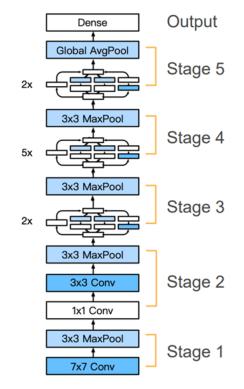

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/architettura generale.png'

image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

Stage 1 and stage 2 are quite similar to the previous ones in AlexNet.

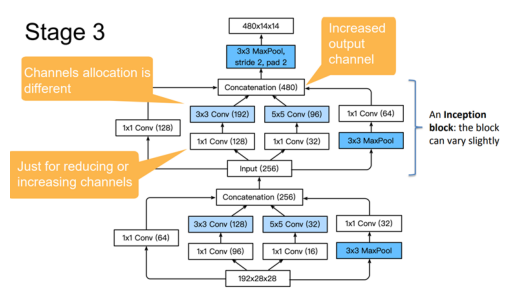

In [ ]:
image_path = '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/stage 3.png'

image = Image.open(image_path)

plt.imshow(image)
plt.axis('off')
plt.show()

As we said previously, the inception blocks are divided into 3 groups. Stage 3 is the first one. It is composed of 2 inception blocks, then we have 5 inception blocks in stage 4 and finally we have again 2 inception blocks in stage 5.

Between a group of inception blocks and another there is MaxPoolig, useful for dimensionality reduction.

As very final step, we have global average pooling that produces the estimates.

# Training phase

Now we train the GoogLeNet architecture based on the train iter dataloader. We have set the learning rate to 0.05 and the number of epochs to 10.

loss 0.748, train acc 0.720, test acc 0.570
257.2 examples/sec on cuda:0


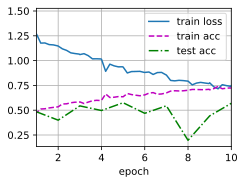

In [ ]:
lr, num_epochs = 0.05, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

The train phase has produced not so high values of train and test accuracy but both of them are above 50%.

In [ ]:
torch.save(net, 'googlenet_weights.pth') #save the model

In [ ]:
googlenet_model = torch.load('googlenet_weights.pth',map_location=torch.device('cpu')) #load the model to use it in a second moment

# Prediction

In the prediction phase we consider the data in test_iter dataloader and the aim is to compare the true labels of the images inside it with the ones predicted by our architecture.

In [ ]:
for x, y in test_iter_DL:
  break
#x , y = x.cuda(), y.cuda()
pred = googlenet_model(x).argmax(axis=1)

We can compare the true labels y and the predicted labels (pred) just by using the confusion matrix. This comparison gives us an idea of how the model behaves in front of new/ unseen data and how it is able to predict the right label.

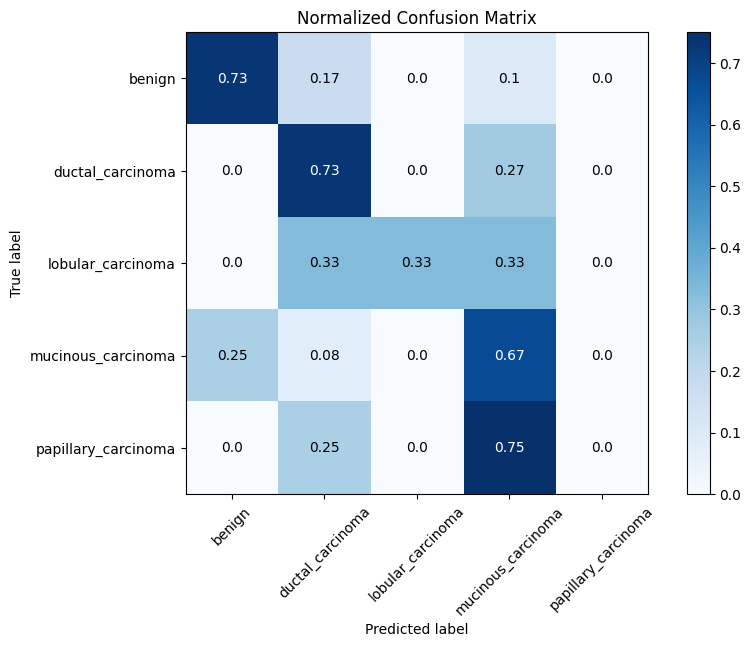

In [ ]:
class_labels = ['benign', 'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']  # Sostituisci con le tue etichette

fig, ax = plt.subplots(figsize=(10, 6))
skplt.metrics.plot_confusion_matrix(y.cpu(), pred.cpu(), normalize=True, cmap = 'Blues', ax=ax)

# Add the labels to x and y axes
tick_marks = range(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.show()

In the main diagonal of the confusion matrix we can observe, for each class, the percentage of correctly identified labels. The model is able to distinguish quite well benign tumors from malignant tumors. This is for sure the most important aspect of tumors classification because malignant tumors are cancerous and should be treated as soon as possible to reduce and prevent further complications.

The other entries of the matrix show the percentages of wrongly identified images. If we read the matrix row by row we can easly see that the only malignant lable that is predicted quite well is ductal carcinoma.

Recall that ductal carcinoma was the category with the highest number of images in the dataset so our model was able to learn from a wide range of different cases. This could be one of the reasons that explains a good performance in recognising that specific category.

On the other hand, it finds more difficult to predict the other types of malignant tumors labels. In partiicular, it never predicts papillary carcinoma but it confuses it with mucinous carcinoma and ductal carcinoma.

Now we are plotting a couple of images displaying the predicted labels and the actual ones.

In [ ]:
# define a function to plot test images with real and predicted labels
import random
def show(net, test_iter, n=6):

  # create two empy list for real and predicted labels
  titles = []
  pred_titles = []

  # define index j to access values in lists above
  j = 0

  # access iteratively data loader elements
  x_iter, y_iter = next(iter(test_iter))

  # make prediction with net model and find most probable class
  pred = net(x_iter).argmax(axis=1)

  # draw n=6 random indexes in order to plot 6 images randomly
  random_idx = random.sample(range(64), n)


  for i in random_idx:
    # access single image and permute it to allow plotting
    img = x_iter[i].permute(1,2,0)

    # associate labels to indexes using ImageFolder classes
    for idx, label in enumerate(breast_test_dataset.classes):

      # check if the index stored in the y variable corresponds to the index of the ImageFolder class
      if y_iter[i] == idx:
        # if yes, appen the label which correspond to that index to the list
        titles.append(label)

      # same reasoning for the predicted classes
      if pred[i].cpu() == idx:
        pred_titles.append(label)

    # plot the image
    plt.imshow(img)
    # add title accessing j-th element in the list
    plt.title(f'True label: {titles[j]} \n Predict label: {pred_titles[j]}')
    # show image
    plt.show()

    # increment the counter to access following elements of the lists
    j+=1

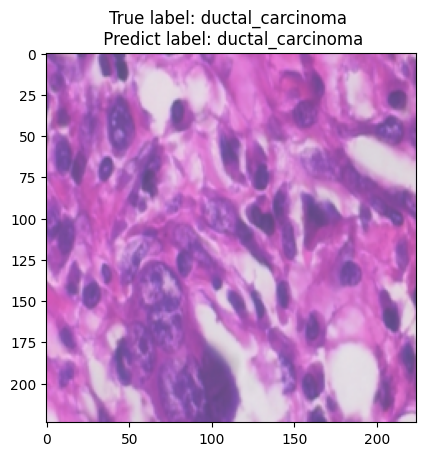

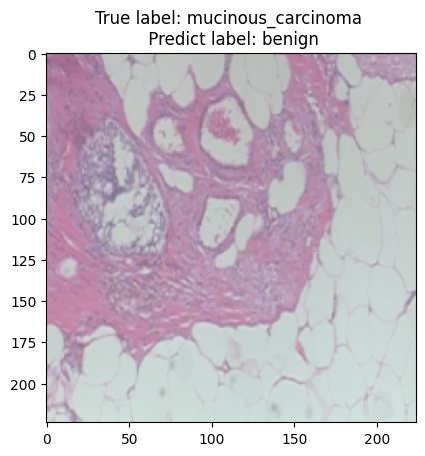

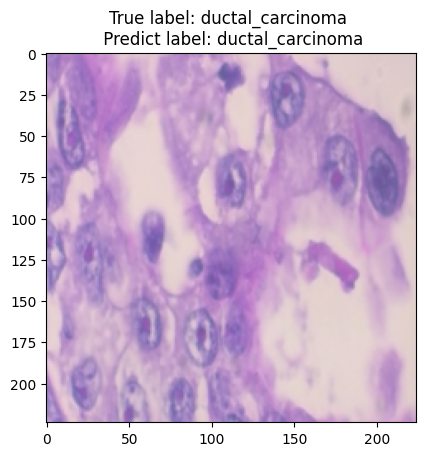

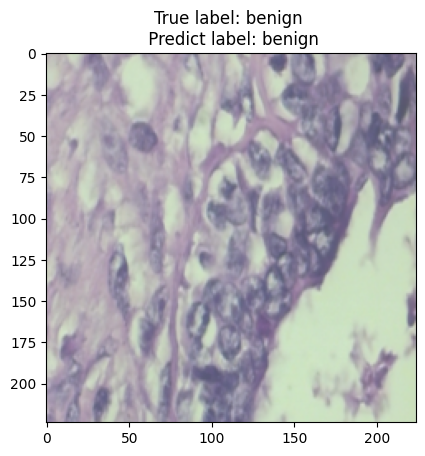

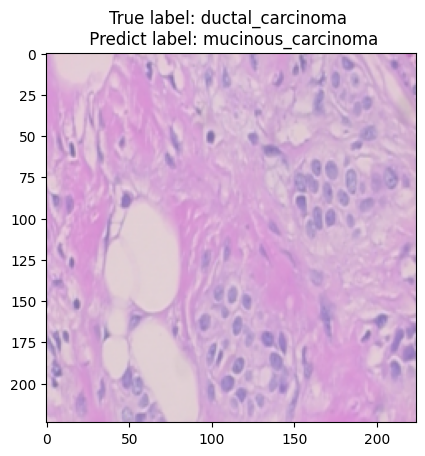

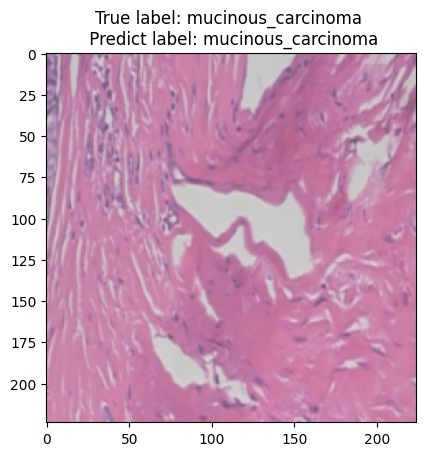

In [ ]:
# plot images
show(googlenet_model, test_iter_DL)